## Experiments to import Datasets from the DeepLagrangianFluids Repository
https://github.com/isl-org/DeepLagrangianFluids/blob/master/datasets/dataset_reader_physics.py

In [ ]:
# %pip install tensorpack zstandard msgpack msgpack_numpy
# %pip install matplotlib

In [2]:
import os
import sys
import numpy as np
from glob import glob
import tensorpack.dataflow as dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

Failed to import tensorflow.


In [3]:
np.arange(5)
np.array_split(np.arange(50), 10)

[array([0, 1, 2, 3, 4]),
 array([5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14]),
 array([15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24]),
 array([25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34]),
 array([35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44]),
 array([45, 46, 47, 48, 49])]

In [12]:
size = 100

split = 0.7, 0.15, 0.15

print(np.arange(size)[:int(size * split[0])])
print(np.arange(size)[int(size * split[0] + 1) : int(size * (split[0] + split[1]))])
print(np.arange(size)[int(size * (split[0] + split[1])) + 1 : ])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[71 72 73 74 75 76 77 78 79 80 81 82 83 84]
[86 87 88 89 90 91 92 93 94 95 96 97 98 99]


In [15]:
import torch
from torch.utils.data import random_split
generator2 = torch.Generator().manual_seed(42)
random_split(range(30), [0.3, 0.3, 0.4], generator=generator2)

In [39]:
np.arange(10)[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [3]:
# Source: https://github.com/isl-org/DeepLagrangianFluids/blob/d651c6fdf2aca3fac9abe3693b20981b191b4769/datasets/dataset_reader_physics.py

class PhysicsSimDataFlow(dataflow.RNGDataFlow):
    """Data flow for msgpacks generated from SplishSplash simulations.
    """

    def __init__(self, files, random_rotation=False, shuffle=False, window=2):
        if not len(files):
            raise Exception("List of files must not be empty")
        if window < 1:
            raise Exception("window must be >=1 but is {}".format(window))
        self.files = files
        self.random_rotation = random_rotation
        self.shuffle = shuffle
        self.window = window

    def __iter__(self):
        decompressor = zstd.ZstdDecompressor()
        files_idxs = np.arange(len(self.files))
        if self.shuffle:
            self.rng.shuffle(files_idxs)

        for file_i in files_idxs:
            # read all data from file
            with open(self.files[file_i], 'rb') as f:
                data = msgpack.unpackb(decompressor.decompress(f.read()),
                                       raw=False)

            data_idxs = np.arange(len(data) - self.window + 1)
            if self.shuffle:
                self.rng.shuffle(data_idxs)

            # get box from first item. The box is valid for the whole file
            box = data[0]['box']
            box_normals = data[0]['box_normals']

            for data_i in data_idxs:

                if self.random_rotation:
                    angle_rad = self.rng.uniform(0, 2 * np.pi)
                    s = np.sin(angle_rad)
                    c = np.cos(angle_rad)
                    rand_R = np.array([c, 0, s, 0, 1, 0, -s, 0, c],
                                      dtype=np.float32).reshape((3, 3))

                if self.random_rotation:
                    sample = {
                        'box': np.matmul(box, rand_R),
                        'box_normals': np.matmul(box_normals, rand_R)
                    }
                else:
                    sample = {'box': box, 'box_normals': box_normals}

                for time_i in range(self.window):

                    item = data[data_i + time_i]

                    for k in ('pos', 'vel'):
                        if self.random_rotation:
                            sample[k + str(time_i)] = np.matmul(item[k], rand_R)
                        else:
                            sample[k + str(time_i)] = item[k]

                    for k in ('m', 'viscosity', 'frame_id', 'scene_id'):
                        sample[k + str(time_i)] = item[k]

                yield sample
    
    
def read_data_val(files, **kwargs):
    return read_data(files=files,
                     batch_size=1,
                     repeat=False,
                     shuffle_buffer=None,
                     num_workers=1,
                     **kwargs)


def read_data_train(files, batch_size, random_rotation=True, **kwargs):
    return read_data(files=files,
                     batch_size=batch_size,
                     random_rotation=random_rotation,
                     repeat=True,
                     shuffle_buffer=512,
                     **kwargs)


def read_data(files=None,
              batch_size=1,
              window=2,
              random_rotation=False,
              repeat=False,
              shuffle_buffer=None,
              num_workers=1,
              cache_data=False):
    print(files[0:20], '...' if len(files) > 20 else '')

    # caching makes only sense if the data is finite
    if cache_data:
        if repeat == True:
            raise Exception("repeat must be False if cache_data==True")
        if random_rotation == True:
            raise Exception("random_rotation must be False if cache_data==True")
        if num_workers != 1:
            raise Exception("num_workers must be 1 if cache_data==True")

    df = PhysicsSimDataFlow(
        files=files,
        random_rotation=random_rotation,
        shuffle=True if shuffle_buffer else False,
        window=window,
    )

    if repeat:
        df = dataflow.RepeatedData(df, -1)

    if shuffle_buffer:
        df = dataflow.LocallyShuffleData(df, shuffle_buffer)

    if num_workers > 1:
        df = dataflow.MultiProcessRunnerZMQ(df, num_proc=num_workers)

    df = dataflow.BatchData(df, batch_size=batch_size, use_list=True)

    if cache_data:
        df = dataflow.CacheData(df)

    df.reset_state()
    return df

In [4]:
os.path.exists('../datasets/data/dpi_dam_break/train/0_00.msgpack.zst')

True

In [5]:
# datasets/data/dpi_dam_break/train/0_00.msgpack.zst
flow = PhysicsSimDataFlow(files=glob('../datasets/data/dpi_dam_break/train/*.msgpack.zst'), random_rotation=False, shuffle=False, window=2)


In [6]:
flow.files

['../datasets/data/dpi_dam_break/train/0_06.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_02.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_03.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_09.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_07.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_10.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_08.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_00.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_04.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_01.msgpack.zst',
 '../datasets/data/dpi_dam_break/train/0_05.msgpack.zst']

In [28]:
decompressor = zstd.ZstdDecompressor()


with open('../datasets/data/dpi_dam_break/train/0_06.msgpack.zst', 'rb') as f:
    data_read = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)



In [31]:
data_read[0]

{'pos': array([[ 5.11716503e-11,  9.09090880e-03,  1.15740374e-01],
        [-1.06609915e-10,  9.09090880e-03,  2.93834880e-02],
        [-2.63635946e-10,  9.09090880e-03,  9.88154560e-02],
        ...,
        [ 1.39329660e+00,  8.64904970e-02,  5.24306476e-01],
        [ 1.23820424e+00,  1.74566984e-01,  6.06098354e-01],
        [ 1.38687742e+00,  7.22770318e-02,  6.26047730e-01]], dtype=float32),
 'vel': array([[ 6.3250964e-09,  0.0000000e+00,  2.3285598e-01],
        [-1.2646600e-08,  0.0000000e+00,  1.6711502e-01],
        [-1.2625804e-08,  0.0000000e+00,  2.4227175e-01],
        ...,
        [ 4.7464371e-01, -7.9608005e-01,  6.2903494e-02],
        [-1.4121488e+00, -1.4736868e-01,  1.7878141e-02],
        [ 1.8269582e-01, -3.0210856e-01, -2.0137049e-01]], dtype=float32),
 'm': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'viscosity': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'box': array([[1.45454550e+00, 1.18044782e+00, 7.30132237e-02],
        [1.45454514e+

In [34]:
data_read[0].keys()

dict_keys(['pos', 'vel', 'm', 'viscosity', 'box', 'box_normals', 'num_rigid_bodies', 'frame_id', 'scene_id'])

In [7]:
x = [item for item in flow]

In [8]:
x[0].keys()

import numpy as np

# print keys and length or shapes
for i in range(2):
    print('---')
    for k, v in x[i].items():
        if (type(v) == np.ndarray):
            print(k, v.shape)
        else:
            print(k, v)

---
box (10683, 3)
box_normals (10683, 3)
pos0 (3456, 3)
vel0 (3456, 3)
m0 (3456,)
viscosity0 (3456,)
frame_id0 60
scene_id0 0
pos1 (3456, 3)
vel1 (3456, 3)
m1 (3456,)
viscosity1 (3456,)
frame_id1 61
scene_id1 0
---
box (10683, 3)
box_normals (10683, 3)
pos0 (3456, 3)
vel0 (3456, 3)
m0 (3456,)
viscosity0 (3456,)
frame_id0 61
scene_id0 0
pos1 (3456, 3)
vel1 (3456, 3)
m1 (3456,)
viscosity1 (3456,)
frame_id1 62
scene_id1 0


In [10]:
# Positions are NOT the same between consecutive frames!

# check if masses in x[0]['m0'] are all the same
for i in range(1, len(x[0]['m0'])):
    assert (x[0]['m0'][0] == x[0]['m0'][i]).all()

for i in range(len(x) - 1):
    print("All positions are the same between consecutive frames:", (x[i]['pos1'] == x[i+1]['pos0']).all())
    print("Masses stay constant between frames:", (x[i]['m0'] == x[i+1]['m0']).all())
    print("Masses stay constant in frame:", (x[i]['m0'] == x[i+1]['m1']).all())



All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between consecutive frames: True
Masses stay constant between frames: True
Masses stay constant in frame: True
All positions are the same between

In [114]:
from utils.visualization import plot_particles

In [115]:
plot_particles(x[0]['pos0'])  # Initial frame
plot_particles(x[0]['box']) # Border particles
plot_particles(x[0]['box_normals'])
plot_particles(x[9]['pos0'])  # Frame when box appears out of nowhere

NameError: name 'x' is not defined

The datasets don't contain density. But they contain border (= Box) particles!
Box normals are a map that contain the direction in which the boarder is facing
Masses for some reason are 0 everywhere.

In [12]:
x[50]['m1']

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [15]:
default_flow = PhysicsSimDataFlow(files=glob('../datasets/data/ours_default_data/train/*.msgpack.zst'), random_rotation=False, shuffle=False, window=2)
default_x = [item for item in default_flow]

In [14]:
default_x[0].keys()

dict_keys(['box', 'box_normals', 'pos0', 'vel0', 'm0', 'viscosity0', 'frame_id0', 'scene_id0', 'pos1', 'vel1', 'm1', 'viscosity1', 'frame_id1', 'scene_id1'])

In [11]:
run_once = False


In [12]:
def enable_parent_folder_import():
    global run_once

    if run_once:
        return

    print("Enable include of parent folder")

    import sys, os
    sys.path.insert(1, os.path.join(sys.path[0], '..'))
    
    run_once = True

enable_parent_folder_import()


Enable include of parent folder


In [14]:
from importlib import reload
import utils.sph
from utils.sph import *
reload(utils.sph); from utils.sph import *

In [15]:
m, h = (0.14245752577013393, 0.04984372318264361)


# initial_particles = torch.concat([torch.tensor(x[0]['pos0']), torch.tensor(x[0]['box'])])
initial_particles = torch.tensor(x[0]['pos0'])
box_velocities = torch.zeros_like(torch.tensor(x[0]['box']))
initial_velocities = torch.concat([torch.tensor(x[0]['vel0']), box_velocities])
masses = torch.ones(len(initial_particles)) * m

In [16]:
initial_density = get_density(point_cloud=initial_particles, masses=masses, smoothing_length=h)
initial_density.shape

torch.Size([3456, 1])

In [17]:
spatial_gradient = get_spatial_density_gradient(point_cloud=initial_particles, masses=masses, densities=initial_density, smoothing_length=h)
spatial_gradient.shape

torch.Size([3456, 3])

In [18]:
temporal_gradient = get_temporal_density_gradient(point_cloud=initial_particles, masses=masses, smoothing_length=h, velocities=initial_velocities)
temporal_gradient.shape

torch.Size([3456, 1])

In [19]:
import plotly.express as px
px.histogram(initial_density).show()
px.histogram(spatial_gradient).show()
px.histogram(temporal_gradient).show()

In [46]:
len(x[0]['pos0']), len(x[0]['box']), len(initial_particles)

(3456, 10683, 14139)

In [56]:
initial_density.detach().numpy()

array([[4376.0186],
       [4287.893 ],
       [4342.5967],
       ...,
       [2309.4458],
       [2516.2185],
       [2544.355 ]], dtype=float32)

In [78]:
d_norm = (d - np.mean(d)) / np.std(d)
d_norm = np.log(d_norm + 1e-6)

/tmp/ipykernel_402/175555948.py:2: RuntimeWarning:

invalid value encountered in log



In [81]:
d_norm= torch.nan_to_num(torch.tensor(d_norm)).detach().numpy()

In [89]:
d_norm.shape

(3456, 1)

In [93]:
d_norm = np.abs(d_norm)
d_norm *= 255.0 / d_norm.max()

d_norm = torch.randn(d_norm.shape).detach().numpy()

In [97]:
d_norm = torch.randn(d_norm.shape).detach().numpy()

In [20]:
px.scatter(initial_density, color = initial_density.reshape(-1))

In [23]:
import plotly.graph_objects as go

d = initial_density.detach().numpy()
# d = temporal_gradient.detach().numpy()
# d = spatial_gradient[:, 2].detach().numpy()

# mean spatial gradient
# d = np.mean(spatial_gradient.detach().numpy(), axis=1)

# FOR COLOR, RESHAPE THE ARRAY!

fig = go.Figure(data=[go.Scatter3d(
    x=initial_particles[:, 0],
    y=initial_particles[:, 2],
    z=initial_particles[:, 1],
    mode='markers',
    marker=dict(
        size=5,
        color=d.reshape(-1),  # set color to an array/list of desired values
        colorscale='Plasma',   # choose a colorscale
        opacity=0.7,
        #cmin=np.min(d),  # Minimum value of color scale
        #cmax=np.max(d)  # Maximum value of color scale
    )
)])

fig.show()



In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [209]:
bb = torch.ones((20,3))
torch.ones((20,3)).view(-1, 2 - 1)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [257]:
from importlib import reload
import datasets.density_dataset
from datasets.density_dataset import SimulationDataset
reload(datasets.density_dataset); from datasets.density_dataset import SimulationDataset
from glob import glob

import utils.sph
from utils.sph import *
reload(utils.sph); from utils.sph import *

import utils.transforms
from utils.transforms import *
reload(utils.transforms); from utils.transforms import *

ds = SimulationDataset(files=glob('../datasets/data/ours_default_data/train/*.msgpack.zst'), transform=None)
sample = ds.__getitem__(0)


<class 'dict'>


In [243]:
torch.ones((20,3)).unsqueeze(-1).shape

torch.Size([20, 3, 1])

In [247]:
import torchvision.transforms as tf
import time

sample = ds.__getitem__(0)
transforms = tf.Compose([
    SampleToTensor(device = 'cpu'),
    AddDensity(include_box=False),
    AddSpatialDensityGradient(include_box=False),
    AddTemporalDensityGradient(include_box=False)
])

# s_to_tensor = SampleToTensor()
# add_density = AddDensity()
# transforms = tf.Compose([s_to_tensor, add_density])
start = time.time()
result = transforms(sample)
end = time.time()
print("Execution time: ", end - start)
result

<class 'dict'>
Execution time:  6.715286493301392


{'pos': tensor([[ 0.1741,  0.0783,  0.3891],
         [-0.5923,  0.0756, -0.2831],
         [ 0.8646,  0.1300,  0.7442],
         ...,
         [-0.6079,  0.1002, -0.1003],
         [-0.5789,  0.1390,  0.7088],
         [ 0.4006,  0.1251, -0.0053]]),
 'vel': tensor([[ 0.0106, -0.0175, -0.0448],
         [ 0.0149, -0.0095, -0.0117],
         [-0.0010, -0.0291,  0.0404],
         ...,
         [-0.0338, -0.0147,  0.0030],
         [ 0.0197,  0.0058,  0.0309],
         [ 0.0454, -0.0014,  0.0229]]),
 'm': tensor([0.1250, 0.1250, 0.1250,  ..., 0.1250, 0.1250, 0.1250]),
 'viscosity': tensor([0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100]),
 'box': tensor([[-1,  2,  0],
         [-1,  2,  0],
         [-1,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]], dtype=torch.int32),
 'box_normals': tensor([[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0]], dtype=torch.int32),


In [250]:
result['density'].shape

torch.Size([5377, 1])

In [249]:
features = torch.cat((result['density'], result['vel']), dim=-1)
features.shape

torch.Size([5377, 4])

In [267]:
from torch.utils.data import DataLoader
ds = SimulationDataset(files=glob('../datasets/data/ours_default_data/train/*.msgpack.zst'), transform=SampleToTensor(device = 'cpu'))
dl = DataLoader(ds, batch_size=2, num_workers=0)
batch = next(iter(dl))

<class 'dict'>
<class 'dict'>


/home/jakob/Bachelorarbeit/GNNDensityGradients/notebooks/../utils/transforms.py:18: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/jakob/Bachelorarbeit/GNNDensityGradients/notebooks/../utils/transforms.py:19: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/jakob/Bachelorarbeit/GNNDensityGradients/notebooks/../utils/transforms.py:20: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/jakob/Bachelorarbeit/GNNDensityGradients/notebooks/../utils/transforms.py:21: UserWarning:

To copy construct from a tensor, it is recommended to us

In [270]:
batch['m'] = batch['m'].unsqueeze(-1)

In [271]:
batch['m'].shape

torch.Size([2, 5377, 1])

In [276]:
# torch.Size([2, 3456, 1]) torch.Size([2, 3456, 3]) 
a, b = torch.rand([2, 3456, 1]), torch.rand([2, 3456, 3])
a = a.cuda()
b = b.cuda()
features = torch.cat((a, b), dim=-1)
print(a.device, b.device, features.device)
features.shape

cuda:0 cuda:0 cuda:0


torch.Size([2, 3456, 4])

In [298]:
from functorch import vmap # care in pytorch 2.0 this will be torch.vmap

In [337]:
radius_search(torch.rand(10,3), torch.rand(10,3), 0.1)

tensor([[3],
        [5]])

In [346]:
torch.arange(5).unsqueeze(0).shape

torch.Size([1, 5])

In [344]:
torch.stack([torch.arange(5), torch.arange(5)])

tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])

In [342]:
# radius_search(x, y, 0.1)

x = lambda x, y: x+y

def test(x, y):
    print(x.shape, y.shape)
    return radius_search(x, y, 0.5)

print(torch.rand(2, 10, 3).shape)
ex1 = torch.rand(2, 10, 3)
ex2 = torch.rand(2, 10, 3)
vmap(test)(ex1, ex2)



torch.Size([2, 10, 3])
torch.Size([10, 3]) torch.Size([10, 3])


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/jakob/anaconda3/envs/o3d_test2/lib/python3.10/site-packages/torch_cluster/radius.py", line 72, in radius
        ptr_y = torch.bucketize(arange, batch_y)

    return torch.ops.torch_cluster.radius(x, y, ptr_x, ptr_y, r,
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
                                          max_num_neighbors, num_workers)
RuntimeError: stack expects each tensor to be equal size, but got [2, 20] at entry 0 and [2, 30] at entry 1


In [ ]:
apply_cubic_kernel_derivative_torch(torch.norm(batch['pos'], dim=-1, keepdim=True), 0.2).shape
print(batch['pos'].shape, batch['pos'].device)
vec_radius_search = vmap(radius_search) # , in_dims=(0, None, None), out_dims=0
vec_radius_search(batch['pos'], batch['pos'], 0.2)

In [277]:
for key in batch.keys():
    if isinstance(batch[key], torch.Tensor):
        print(key, batch[key].shape)

pos torch.Size([2, 5377, 3])
vel torch.Size([2, 5377, 3])
m torch.Size([2, 5377, 1])
viscosity torch.Size([2, 5377])
box torch.Size([2, 39086, 3])
box_normals torch.Size([2, 39086, 3])
frame_id torch.Size([2])


In [236]:
import utils.sph
from utils.sph import *
reload(utils.sph); from utils.sph import *

plot_particles(sample[0]['pos'], sample[0]['density'])
plot_particles(sample[0]['pos'], torch.norm(sample[0]['spatial_density_gradient'], dim=1))
plot_particles(sample[0]['pos'], sample[0]['temporal_density_gradient'])

In [174]:
import plotly.express as px
px.histogram(sample[0]['density'].cpu().detach().numpy())

In [175]:
px.histogram(sample[0]['pos'].cpu().detach().numpy())

In [165]:
from torch_geometric.nn import radius as radius_search
point_cloud = torch.rand(3, 3)
radius = 0.3 * 3.3

total_particles = point_cloud
total_particles = torch.concat([point_cloud, (torch.rand(3, 3))])
pairs = radius_search(x=total_particles, y=point_cloud, r=radius, max_num_neighbors=2048)
pairs

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2],
        [0, 1, 2, 3, 4, 5, 0, 1, 3, 5, 0, 2, 3, 4, 5]])

In [169]:
pairs[0] != pairs[1]
pairs[:,pairs[0] != pairs[1]]

# no index in pairs[0] can appear at the same place in pairs[2]


tensor([[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2],
        [1, 2, 3, 4, 5, 0, 3, 5, 0, 3, 4, 5]])

In [239]:
import random
random.choice([1, 2, 3])

2

In [2]:
import torch
torch.rand((10,3)).dim()

2

In [6]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [188]:
from importlib import reload
import datasets.density_dataset
from datasets.density_dataset import SimulationDataset
reload(datasets.density_dataset); from datasets.density_dataset import SimulationDataset
from glob import glob

import utils.sph
from utils.sph import *
reload(utils.sph); from utils.sph import *

import utils.transforms
from utils.transforms import *
reload(utils.transforms); from utils.transforms import *

import datasets.density_data_module
from datasets.density_data_module import DensityDataModule
reload(datasets.density_data_module); from datasets.density_data_module import DensityDataModule

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)
dm = DensityDataModule(data_dir='../datasets/data/dpi_dam_break/train', batch_size=1, data_split=(0.7, 0.15, 0.15), num_workers=0, device=device)
dm.setup('fit')

Using device:  cuda
Setting up data module for stage  fit


In [189]:
train_loader = dm.train_dataloader()

it = iter(train_loader)

In [190]:
batch = next(it)

In [98]:
batch['m'].squeeze(0).shape

torch.Size([3456, 1])

In [172]:
torch.std(batch['temporal_density_gradient'])
for key in batch.keys():
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].squeeze(0)

In [173]:
from utils.visualization import plot_particles
plot_particles(batch['pos'], torch.norm(batch['vel'], dim=-1))
plot_particles(batch['pos'], batch['density'], colorscale='Plasma')
plot_particles(batch['pos'], batch['temporal_density_gradient'], colorscale='thermal')

In [133]:
torch.mean(batch['density']), torch.std(batch['density'])
torch.mean(batch['temporal_density_gradient']), torch.std(batch['temporal_density_gradient'])
torch.mean(batch['spatial_density_gradient'], dim=1), torch.std(batch['spatial_density_gradient'], dim=1)

(tensor([[ 2.2076e-09, -2.2076e-09, -4.4152e-09]], device='cuda:0'),
 tensor([[1., 1., 1.]], device='cuda:0'))

### Test callbacks that visualize density gradient

In [191]:
from utils.callbacks import VisualizePredictionCallback
from models.cconv import CConvModel

model = CConvModel()

vispred = VisualizePredictionCallback(model=model, dataset=dm.train_dataloader(), dataset_type="train")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [193]:
dm.dataset['train']

In [269]:
"train".capitalize() + " dataset sample"

'Train dataset sample'

In [264]:
import utils.visualization
from utils.visualization import visualize_model_fig, fig_to_tensor, SaveOutputHandler
reload(utils.visualization); from utils.visualization import visualize_model_fig, fig_to_tensor, SaveOutputHandler

visualize_model_fig(model, dm.dataset['train'], same_color_axis=True, title="Train", width = 1000, height = 450)

In [197]:
sample = dm.dataset['train'].__getitem__(0)

In [205]:
dm.dataset['train'].__getitem__(0)['pos'].shape

torch.Size([3456, 3])

In [198]:
sample['pos']

tensor([[0.0000, 0.0091, 0.1192],
        [0.0000, 0.0091, 0.0561],
        [0.0000, 0.0091, 0.1059],
        ...,
        [1.3749, 0.2891, 0.6514],
        [1.3876, 0.3473, 0.6733],
        [1.3752, 0.3284, 0.7285]], device='cuda:0')

In [248]:

t = fig_to_tensor(visualize_model_fig(model, dm.dataset['train'], same_color_axis=True, height=700))
t.shape

TypeError: visualize_model_fig() got an unexpected keyword argument 'height'

In [234]:
# initiate tensorboard and save image

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='../lightning_logs')

writer.add_image('Visualization', t, 0)

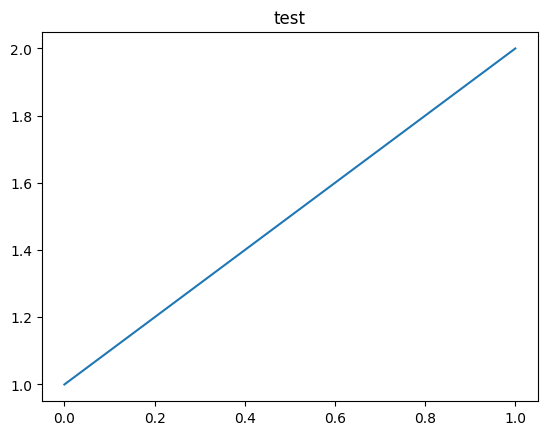

In [7]:
import matplotlib.pyplot as plt
import io


def gen_plot():
    """Create a pyplot plot and save to buffer."""
    plt.figure()
    plt.plot([1, 2])
    plt.title("test")
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return buf


# Prepare the plot
plot_buf = gen_plot()


In [1]:
import sys, os
from importlib import reload
sys.path.insert(1, os.path.join(sys.path[0], '..'))

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

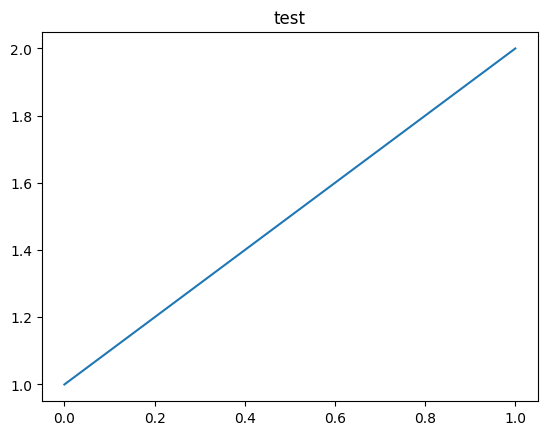

<Figure size 640x480 with 0 Axes>

In [22]:

def gen_plot():
    """Create a pyplot plot and save to buffer."""
    plt.figure()
    plt.plot([1, 2])
    plt.title("test")
    return plt.figure()

import utils.visualization
from utils.visualization import visualize_model_fig, fig_to_tensor, SaveOutputHandler
reload(utils.visualization); from utils.visualization import visualize_model_fig, fig_to_tensor, SaveOutputHandler

fig_to_tensor(gen_plot())

In [17]:
import plotly.express as px
type(io.BytesIO(px.scatter(x=[1,2,3], y=[1,2,3]).to_image(format="png")))

NameError: name 'io' is not defined

In [37]:
import datasets.density_dataset
from datasets.density_dataset import *
reload(datasets.density_dataset); from datasets.density_dataset import *

import utils.train_helper
from utils.train_helper import *
reload(utils.train_helper); from utils.train_helper import *

ds = SimulationDataset(files=glob('../datasets/data/dpi_dam_break/train/*.msgpack.zst'), cache=True)


Loading dataset into memory
Done loading dataset into memory


In [36]:
ds.__getitem__(800)['box']


tensor([[1.4545, 1.2074, 0.3093],
        [1.4545, 1.2118, 0.3535],
        [1.4545, 1.2092, 0.3818],
        ...,
        [1.0738, 0.5659, 0.0000],
        [0.6017, 0.8483, 0.7273],
        [0.5269, 1.7464, 0.7273]])

In [10]:
generate_map('../datasets/data/dpi_dam_break/train')

Found 131 files with 1239 simulation states.
Writing map to ../datasets/data/dpi_dam_break/train/_simulation_states.pkl


In [13]:

with open('../datasets/data/dpi_dam_break/train/_simulation_states.pkl', 'rb') as f:
    result = pickle.load(f)

len(result)

1239

In [18]:
result[90:107]

[(90, 2, 9, 88, '0_09.msgpack.zst', 90, '0'),
 (91, 3, 9, 88, '0_09.msgpack.zst', 91, '0'),
 (92, 4, 9, 88, '0_09.msgpack.zst', 92, '0'),
 (93, 5, 9, 88, '0_09.msgpack.zst', 93, '0'),
 (94, 6, 9, 88, '0_09.msgpack.zst', 94, '0'),
 (95, 7, 9, 88, '0_09.msgpack.zst', 95, '0'),
 (96, 8, 9, 88, '0_09.msgpack.zst', 96, '0'),
 (97, 0, 10, 97, '0_10.msgpack.zst', 97, '0'),
 (98, 1, 10, 97, '0_10.msgpack.zst', 98, '0'),
 (99, 2, 10, 97, '0_10.msgpack.zst', 99, '0'),
 (100, 3, 10, 97, '0_10.msgpack.zst', 100, '0'),
 (101, 4, 10, 97, '0_10.msgpack.zst', 101, '0'),
 (102, 5, 10, 97, '0_10.msgpack.zst', 102, '0'),
 (103, 6, 10, 97, '0_10.msgpack.zst', 103, '0'),
 (104, 7, 10, 97, '0_10.msgpack.zst', 104, '0'),
 (105, 8, 10, 97, '0_10.msgpack.zst', 105, '0'),
 (106, 0, 11, 106, '0_11.msgpack.zst', 106, '0')]

In [23]:
# (i, in_file_id, file_id, box_id, basename, frame_id, scene_id)
ds.__getitem__(104)['pos'].shape

torch.Size([3456, 3])

In [39]:
from importlib import reload
import datasets.density_dataset
from datasets.density_dataset import SimulationDataset
reload(datasets.density_dataset); from datasets.density_dataset import SimulationDataset
from glob import glob

import utils.sph
from utils.sph import *
reload(utils.sph); from utils.sph import *

import utils.transforms
from utils.transforms import *
reload(utils.transforms); from utils.transforms import *

import datasets.density_data_module
from datasets.density_data_module import DensityDataModule
reload(datasets.density_data_module); from datasets.density_data_module import DensityDataModule

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)
dm = DensityDataModule(data_dir='../datasets/data/dpi_dam_break/train', batch_size=1, data_split=(0.7, 0.15, 0.15), num_workers=0, device=device, cache=True)
dm.setup('fit')

Using device:  cuda
Setting up data module for stage  fit
Loading dataset into memory and applying transform_once... (Device: cuda)


100%|██████████| 131/131 [01:19<00:00,  1.65it/s]

Done loading dataset into memory


In [40]:
train_loader = dm.train_dataloader()

it = iter(train_loader)

In [43]:
shapes = [batch['pos'].shape for batch in it]

In [51]:
torch.tensor(5)

tensor(5)

In [52]:
(torch.stack([torch.tensor(len(shape)) for shape in shapes]) == 3).all()

tensor(True)

In [55]:
batch['temporal_density_gradient'].shape

torch.Size([1, 3456, 1])